# **Cassava ResNet50 fine-tuning**
2021/01/12 written by T.Yonezu

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader, Dataset

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import glob 
import os
from tqdm import tqdm

from cassava_dataset import *
from myvgg import *
from augmentation import *

import warnings
warnings.simplefilter('ignore')


In [2]:
input_dir = os.path.join('..',"..", 'input', 'cassava-leaf-disease-classification')

## **Fine-tuning**

In [3]:
x = pd.read_csv(os.path.join(input_dir, 'train.csv'))
x["image_path"] = os.path.join(input_dir,"train_images")
x["image_path"] = x["image_path"].str.cat(x["image_id"], sep=os.path.sep)

train_df = x
train_df = EqualizeLabels(train_df,NUM=15000)

train_dict = dict( zip(train_df["image_path"],train_df["label"]) )

In [4]:
size = (224,224)
mean = [0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform = ImageTransform(size,mean,std)

In [5]:
BATCH_SIZE = 10
NUM_WORKERS = 8

train_data = CassavaDataset(train_dict,transform=transform)
train_data = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)

In [6]:
EPOCH_NUM = 50

OUT_DIR = os.path.join("..","..","input","cassava-models")
MODEL_NAME = "ResNet50_cassava_EqualizedLabel_trained_%dEpoch.mdl"
PATH = os.path.join(OUT_DIR,MODEL_NAME%EPOCH_NUM)

In [7]:
import torchvision.models as models

model = models.resnet50(pretrained=False)
model.fc = nn.Linear(in_features=2048, out_features=5, bias=True)

#model

  2%|█▌                                                                              | 1/50 [04:37<3:46:45, 277.66s/it]

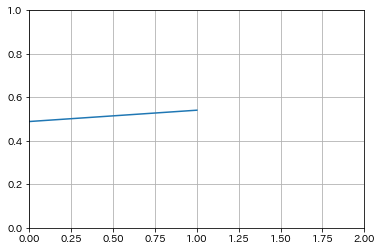

 22%|█████████████████▍                                                             | 11/50 [50:29<2:58:57, 275.33s/it]

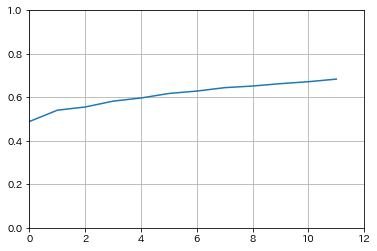

 42%|████████████████████████████████▎                                            | 21/50 [1:36:29<2:13:22, 275.93s/it]

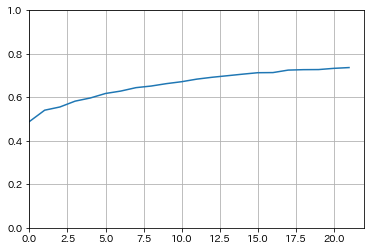

 62%|███████████████████████████████████████████████▋                             | 31/50 [2:22:34<1:27:31, 276.42s/it]

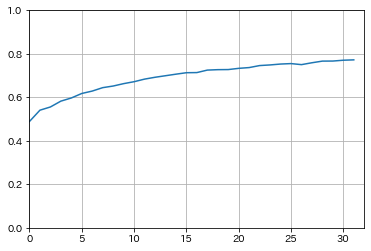

 82%|████████████████████████████████████████████████████████████████▊              | 41/50 [3:08:34<41:25, 276.17s/it]

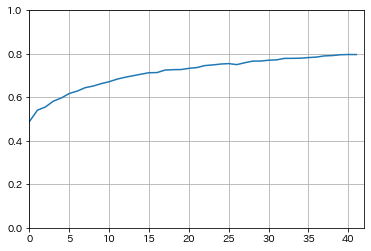

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [3:49:58<00:00, 275.97s/it]


In [8]:
import torch.optim as optim
from torch import nn

model = model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

model.train()
acc_log = {}
for epoch in tqdm(range(EPOCH_NUM)):
    
    acc = np.array([])
    
    for batch in (train_data):
        
        X = batch[0].cuda()
        y = batch[1].cuda()
        pred = model(X)
        
        # zero the gradient buffers
        optimizer.zero_grad()
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step() # Does the update
        
        
        pred_label = ( pred.argmax(axis=1) ).cpu().numpy()
        y = y.cpu().numpy()
        acc = np.append(acc, pred_label == y)
    
    acc_log[epoch] = acc.sum()/len(acc)
    
    if epoch%10 == 1:
        pd.Series(acc_log).plot()
        plt.grid(True)
        plt.ylim(0,1)
        plt.xlim(0,EPOCH+1)
        plt.show()
        
        

if not(os.path.exists(OUT_DIR)):
    os.makedirs(OUT_DIR)
torch.save(model.state_dict(),PATH)